<a href="https://colab.research.google.com/github/ThomasMcDaniel91/DS-Unit-2-Applied-Modeling/blob/master/DS-Unit-2-Applied-Modeling/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [31]:
!pip install category_encoders==2.*
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

In [3]:
from google.colab import files
uploaded = files.upload()

Saving video-game-sales-with-ratings.zip to video-game-sales-with-ratings.zip


In [0]:
df = pd.read_csv('video-game-sales-with-ratings.zip')

In [70]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
sales = df[['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']].sum()
sales
sales_col = ['North America',	'Europe',	'Japan',	'Other']

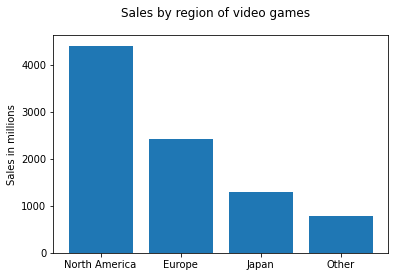

In [72]:
fig, ax = plt.subplots()
ax.bar(sales_col, sales)
fig.suptitle('Sales by region of video games')
plt.ylabel('Sales in millions')
plt.show()

In [0]:
df = df.drop('Name', axis=1)

In [74]:
#establishing a baseline of Global Sales
#The baseline for MAE is .588 or 588,293 dollars
base = df['Global_Sales'].mean()
base = [base] * len(df['Global_Sales'])
baseline = mean_absolute_error(df['Global_Sales'], base)
baseline

0.5882939537553928

In [0]:
#cleaning out nan values by replacing the rating with the mean and genre with most
#common genre
df['Rating'] = df['Rating'].replace({np.nan: df['Rating'].mean})
df['Genre'] = df['Genre'].replace({np.nan: df['Genre'].mode})

In [0]:
df['User_Score'] = df['User_Score'].replace({'tbd': np.nan})
df['User_Score'] = pd.to_numeric(df['User_Score'])

In [0]:
df['User_Score'] = df['User_Score'].replace({np.nan: df['User_Score'].mean()})

In [78]:
df['User_Score'].dtype

dtype('float64')

In [0]:
#testing basic random forest regression
target = 'Global_Sales'

features = df.drop(columns=[target, 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
#train_feats = features.select_dtypes(include='number').columns.tolist()
df[train_feats] = df[train_feats].replace({np.nan: df[train_feats].mean()})

In [0]:
train, test = train_test_split(df, train_size=0.90, random_state=2)

In [0]:
#checking the shapes of my splits(12,037 train, 3,010 val, 1,672 test)
train, val = train_test_split(train, train_size=0.8, random_state=2)

In [82]:
train.shape, val.shape, test.shape

((12037, 15), (3010, 15), (1672, 15))

In [0]:
#making my features and targets on split dataframes
X_train = train[train_feats]
y_train = train[target]

X_val = val[train_feats]
y_val = val[target]

In [0]:
pipeline = make_pipeline(
    SimpleImputer(),
    ce.OneHotEncoder(use_cat_names=True),
    RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=3)
)

In [85]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=5,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_sampl

In [86]:
#basic random tree regression model MAE is .480 or 480,000 dollars off on average
#beating the baseline of 588,293
y_pred = pipeline.predict(X_val)
model_val = mean_absolute_error(y_val, y_pred)
model_val

0.4803814063462392

In [0]:
rf = pipeline.named_steps['randomforestregressor']
rf.feature_importances_.shape
#X_train.columns.shape
importances = pd.DataFrame({'importances': list(rf.feature_importances_), 'features': list(X_train.columns)})

# plt.figure(figsize=(10, 10))
# importances.sort_values()[:].plot.barh();

In [67]:
import altair as alt
alt.Chart(importances).mark_bar().encode(x='features',
                                         y='importances',
                                         color=alt.Color('importances', scale=alt.Scale(scheme='blueorange')),
                                         tooltip=['importances']).interactive().properties(width=500)

alt.Chart(...)

In [41]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    XGBRegressor(n_estimators=20, max_depth=5, random_state=2, n_jobs=-2)
)
pipeline.fit(X_train, y_train)

[20:19:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=None, n_estimators=20, n_jobs=-2,
                              nthread=None, objective='reg:linear',
                              random_state=2, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1)

In [39]:
#standard xgboosting improved my score by ~20,000 dollars on average
y_pred = pipeline.predict(X_val)
boost_mae = mean_absolute_error(y_val, y_pred)
boost_mae

0.4616348115582007